# Extract the skin from a mesh {#ref_skin_mesh}

Extracting the skin of a mesh to reduce the amount of data to operate on
can be useful for specific results and for performance.


In [1]:
# Import necessary modules
from ansys.dpf import core as dpf
from ansys.dpf.core import examples
from ansys.dpf.core import operators as ops

Create a model object to establish a connection with an example result
file and then extract:


In [2]:
model = dpf.Model(examples.download_multi_stage_cyclic_result())
print(model)

DPF Model
------------------------------
Modal analysis
Unit system: MKS: m, kg, N, s, V, A, degC
Physics Type: Mechanical
Available results:
     -  displacement: Nodal Displacement
     -  stress: ElementalNodal Stress 
     -  elastic_strain: ElementalNodal Strain
     -  structural_temperature: ElementalNodal Temperature
------------------------------
DPF  Meshed Region: 
  3595 nodes 
  1557 elements 
  Unit: m 
  With solid (3D) elements
------------------------------
DPF  Time/Freq Support: 
  Number of sets: 6 
Cumulative     Frequency (Hz) LoadStep       Substep        Harmonic index  
1              188.385357     1              1              0.000000        
2              325.126418     1              2              0.000000        
3              595.320548     1              3              0.000000        
4              638.189511     1              4              0.000000        
5              775.669703     1              5              0.000000        
6            

# Create the workflow

Maximum principal stress usually occurs on the skin of the model.
Computing results only on this skin reduces the data size.


In [3]:
# Create a simple workflow computing the principal stress on the skin
# of the model.

skin_op = ops.mesh.external_layer(model.metadata.meshed_region)
skin_mesh = skin_op.outputs.mesh()

Plot the mesh skin:


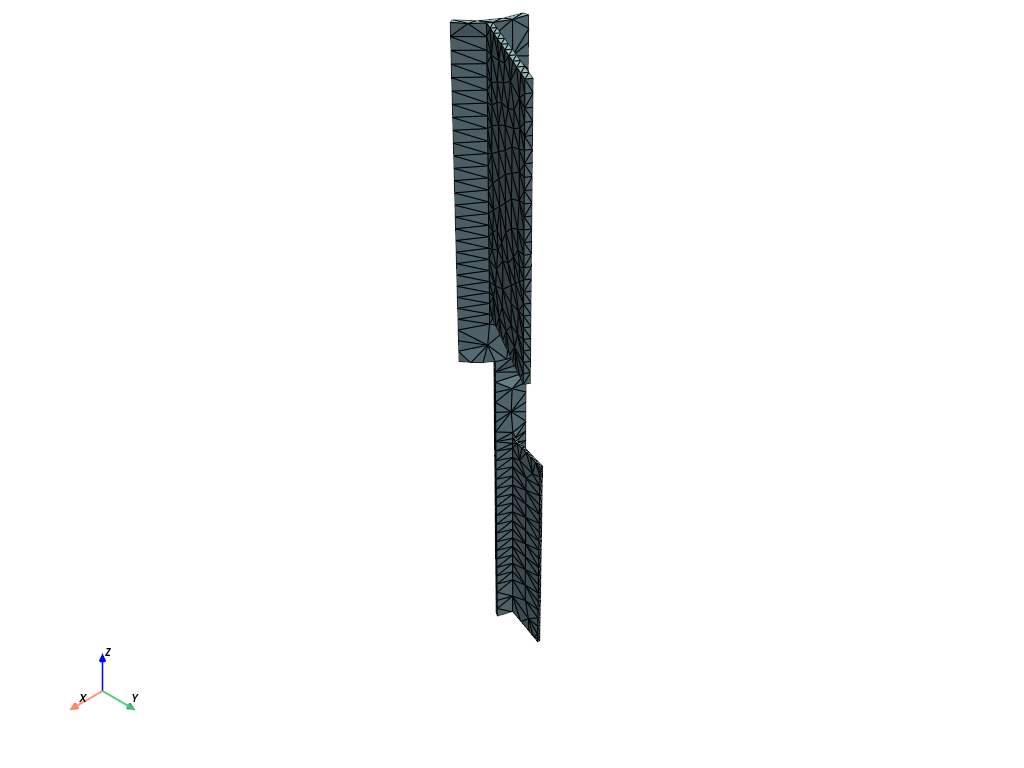

In [4]:
skin_mesh.plot()

Compute the stress principal invariants on the skin nodes only:


In [5]:
stress_op = ops.result.stress(data_sources=model.metadata.data_sources)
stress_op.inputs.requested_location.connect(dpf.locations.nodal)
stress_op.inputs.mesh_scoping.connect(skin_op.outputs.nodes_mesh_scoping)

principal_op = ops.invariant.principal_invariants_fc(stress_op)
principal_stress_1 = principal_op.outputs.fields_eig_1()[0]
principal_stress_2 = principal_op.outputs.fields_eig_2()[0]
principal_stress_3 = principal_op.outputs.fields_eig_3()[0]

# Manipulate data locally


This example goes over the fields, keeping the largest invariant value
by node if the averaged value of invariants is large enough. Exploring
data allows you to customize it to meet your needs.


In [6]:
node_scoping_ids = principal_stress_1.scoping.ids
threshold = 300000.0

field_to_keep = dpf.fields_factory.create_scalar_field(
    len(node_scoping_ids), location=dpf.locations.nodal
)

with field_to_keep.as_local_field() as f:
    with principal_stress_1.as_local_field() as s1:
        with principal_stress_2.as_local_field() as s2:
            with principal_stress_3.as_local_field() as s3:
                for i, id in enumerate(node_scoping_ids):
                    d1 = abs(s1.get_entity_data_by_id(id))
                    d2 = abs(s2.get_entity_data_by_id(id))
                    d3 = abs(s3.get_entity_data_by_id(id))
                    if (d1 + d2 + d3) / 3.0 > threshold:
                        d = max(d1, d2, d3)
                        f.append(d, id)

# Plot result field


Plot the result field on the skin mesh:


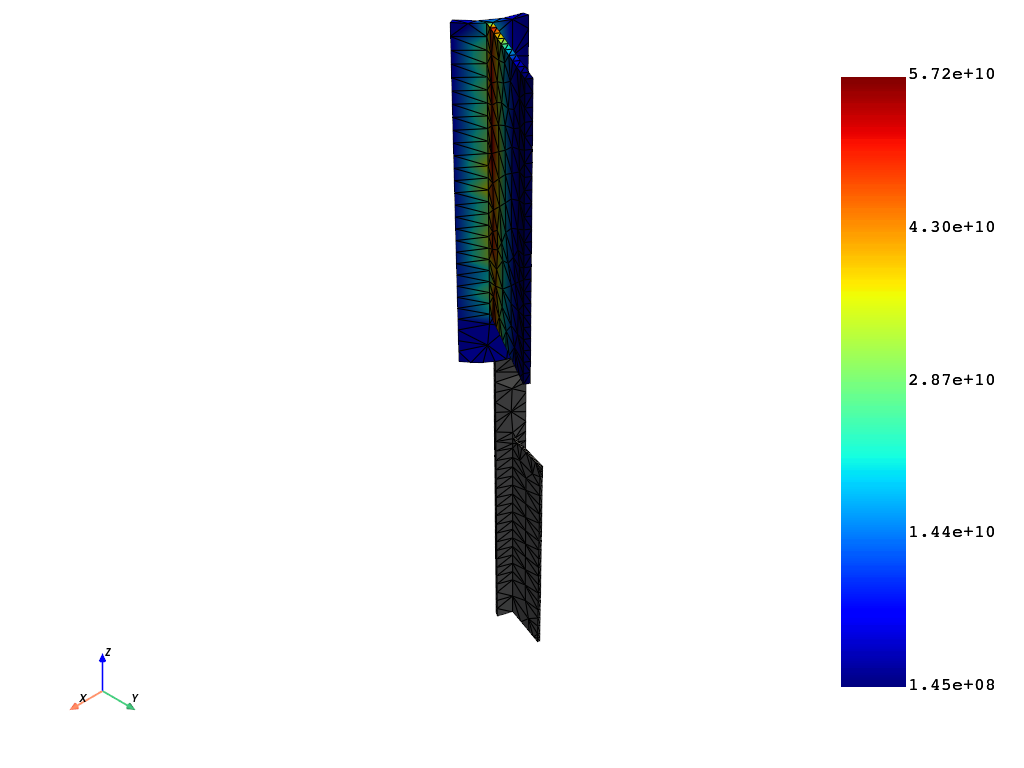

In [7]:
skin_mesh.plot(field_to_keep)

# Plot initial invariants


Plot the initial invariants on the skin mesh:


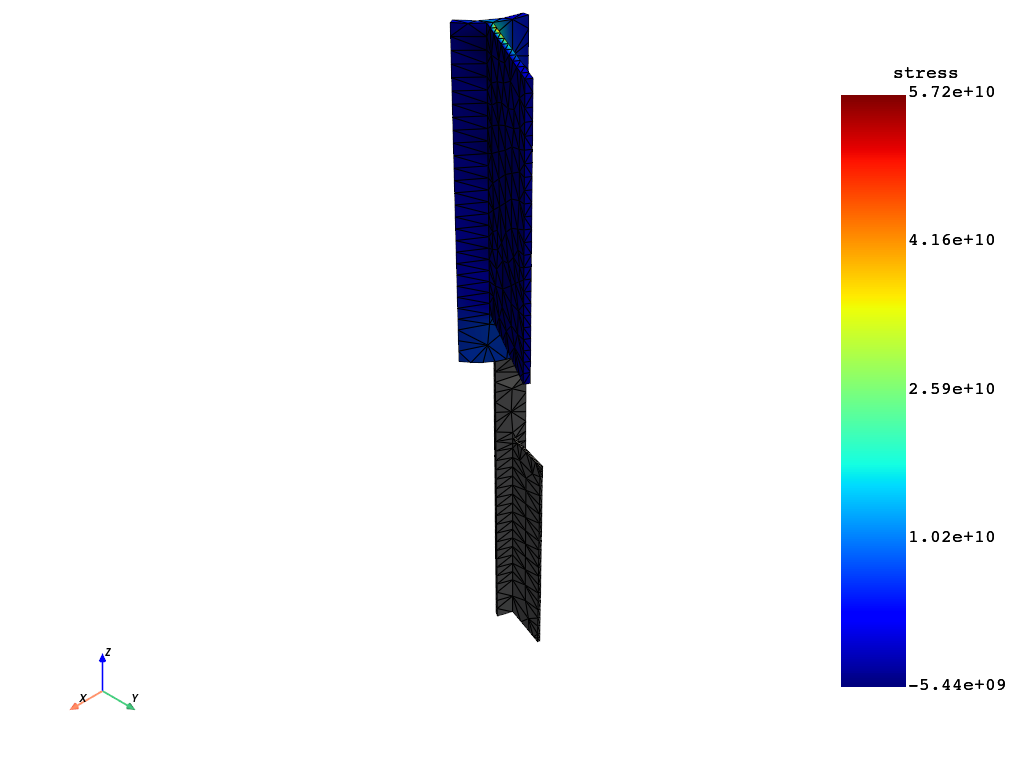

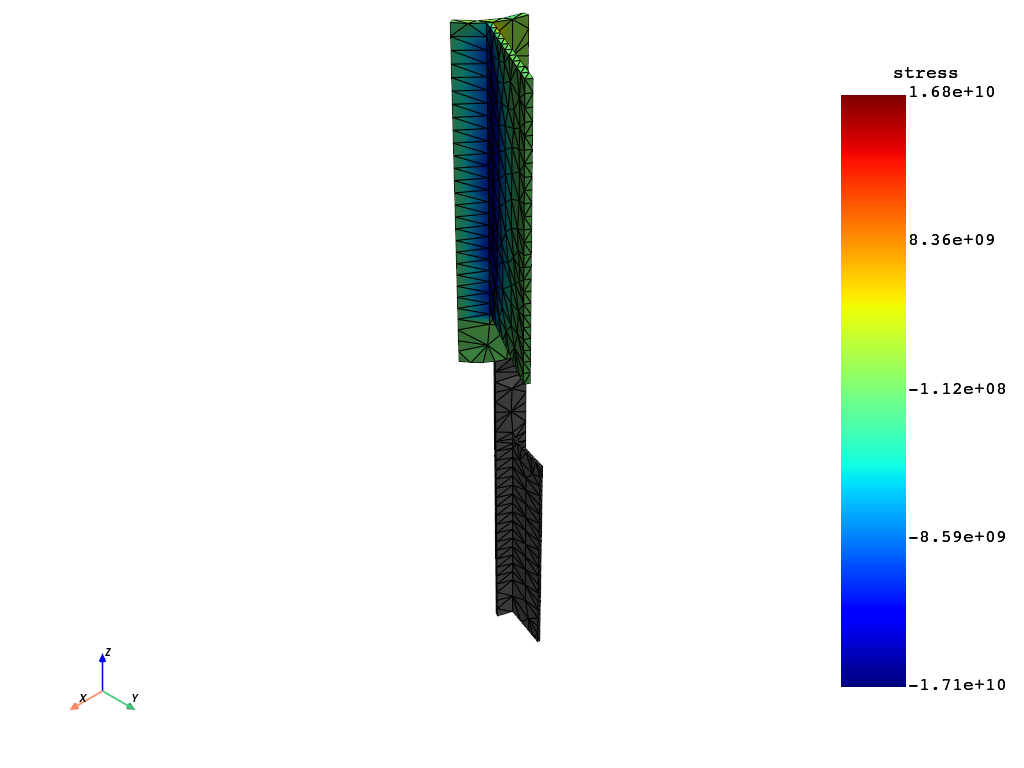

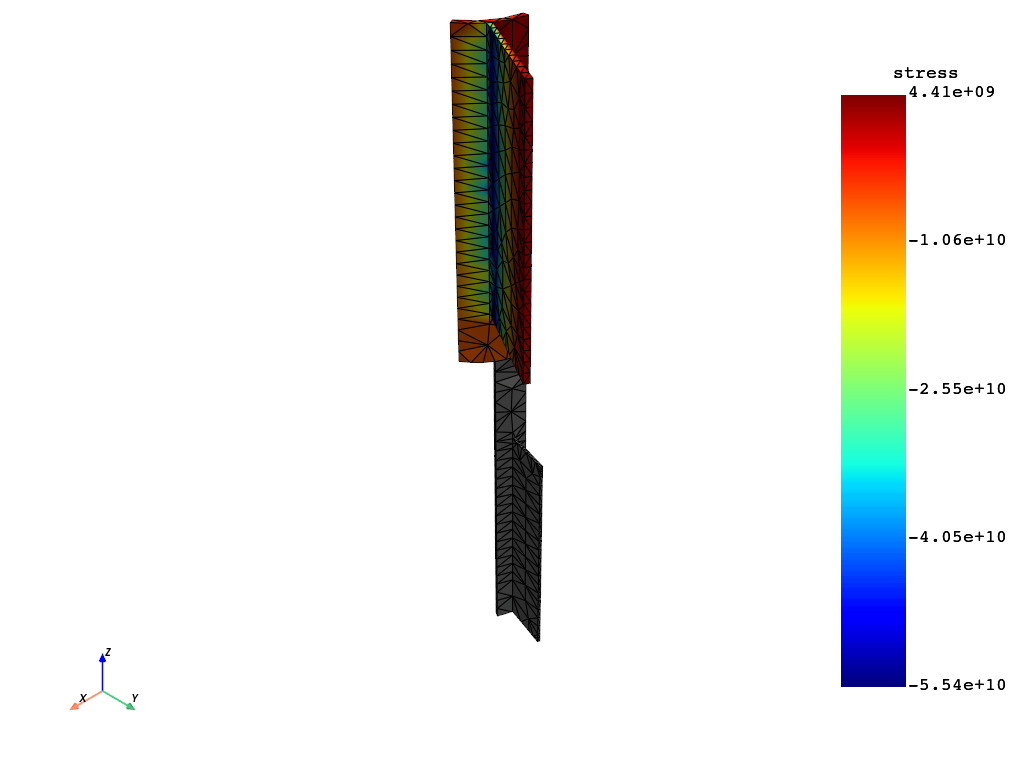

In [8]:
skin_mesh.plot(principal_stress_1)
skin_mesh.plot(principal_stress_2)
skin_mesh.plot(principal_stress_3)